In [1]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm_notebook
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU

print(torch.cuda.is_available())
num_classes = 10
batch_size = 64

True


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LeNet5(nn.Module):
  def __init__(self,num_classes):
    super(LeNet5,self).__init__()
    self.layerbunch1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),#layer -1
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) #layer - 2
    )
    self.layerbunch2 = nn.Sequential(
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0), #layer -3
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) #layer -4
    )
    self.layerbunch3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0), #layer -5
        nn.ReLU()
    )
    self.fulllayer1 = nn.Linear(in_features=120, out_features=84, bias = True) #layer -6
    self.relu = nn.ReLU()
    self.fulllayer2 = nn.Linear(in_features=84, out_features=num_classes, bias = True) #layer -7 (final layer)


  def forward(self, x):
    output = self.layerbunch1(x)
    output = self.layerbunch2(output)
    output = self.layerbunch3(output)
    output = output.reshape(output.size(0), -1)
    output = self.fulllayer1(output)
    output = self.relu(output)
    output = self.fulllayer2(output)

    return output

In [3]:
from torch.utils.data import dataset
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train = True, 
                                           transform= transforms.Compose(
                                               [transforms.Resize((32,32)), 
                                                transforms.ToTensor(), ]),
                                                download=True
                                                
)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train = False, 
                                           transform= transforms.Compose(
                                               [transforms.Resize((32,32)), 
                                                transforms.ToTensor(), ]),
                                                download=True
)

train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 64, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 323506110.09it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 90063712.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 122659159.62it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7697183.34it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
learning_rate = 0.001
model = LeNet5(num_classes).to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [5]:
def train(model, criterion, optimizer, num_epochs=10):
  global total_training_loss 
  train_arr = []
  
  total_step = len(train_dataloader)

  for epoch in range(num_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_dataloader):
      images = images.to(device)
      labels = labels.to(device)

      # forward pass
      output = model(images)
      loss = criterion(output, labels)

      # backward and optimize
      optimizer.zero_grad() #setting prev grad to zero
      loss.backward() #calculating new gradient
      running_loss += loss.item() * images.size(0)
      optimizer.step() 

      total_training_loss = loss.item()
      train_arr.append(total_training_loss)
      plt.plot(train_arr)

    return total_training_loss

In [6]:
def evaluate(test_dataloader, model, criterion, num_epochs=10):
  global total_valid_loss 
  val_arr = []
  running_loss = 0
  model.eval()
  for j, (images, labels) in enumerate(test_dataloader):
    images = images.to(device)
    labels = labels.to(device) 

    output = model(images)
    loss = criterion(output, labels)
    running_loss += loss.item() * images.size(0)

    total_valid_loss = loss.item()
    val_arr.append(total_valid_loss)
    plt.plot(val_arr)
    
  return total_valid_loss

In [7]:
def accuracy(model, data_loader, device):
    
    correct_pred = 0
    n = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:

            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            _, predicted_labels = output.max(1)

            n += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

    return correct_pred.float()/ n

In [8]:
def final_loop(train_dataloader,test_dataloader,model, criterion, optimizer, num_epochs=10):
  

  for epoch in range(1, num_epochs):
    
      total_training_loss = train(model, criterion, optimizer, num_epochs=10)
      total_valid_loss = evaluate(test_dataloader, model, criterion, num_epochs = 10)       
      train_acc = accuracy(model, train_dataloader, device=device)
      valid_acc = accuracy(model, test_dataloader, device=device)
                  

      print(
            f'Epoch: {epoch}\t')
      print(f'Train loss: {total_training_loss:.4f}\t')
      print(f'Valid loss: {total_valid_loss:.4f}\t')
      print(f'Train accuracy: {100 * train_acc:.2f}\t')
      print(f'Valid accuracy: {100 * valid_acc:.2f}')

  return model, optimizer , (total_training_loss, total_valid_loss) 

Epoch: 1	
Train loss: 0.0539	
Valid loss: 0.0522	
Train accuracy: 97.17	
Valid accuracy: 97.38
Epoch: 2	
Train loss: 0.0302	
Valid loss: 0.0116	
Train accuracy: 97.62	
Valid accuracy: 97.74
Epoch: 3	
Train loss: 0.1581	
Valid loss: 0.0281	
Train accuracy: 97.95	
Valid accuracy: 97.99
Epoch: 4	
Train loss: 0.0904	
Valid loss: 0.0426	
Train accuracy: 98.93	
Valid accuracy: 98.77
Epoch: 5	
Train loss: 0.0033	
Valid loss: 0.0009	
Train accuracy: 99.06	
Valid accuracy: 98.67
Epoch: 6	
Train loss: 0.0031	
Valid loss: 0.0131	
Train accuracy: 99.27	
Valid accuracy: 98.87
Epoch: 7	
Train loss: 0.0011	
Valid loss: 0.0295	
Train accuracy: 99.11	
Valid accuracy: 98.79
Epoch: 8	
Train loss: 0.0027	
Valid loss: 0.0004	
Train accuracy: 99.29	
Valid accuracy: 98.64
Epoch: 9	
Train loss: 0.0025	
Valid loss: 0.1211	
Train accuracy: 99.43	
Valid accuracy: 98.79


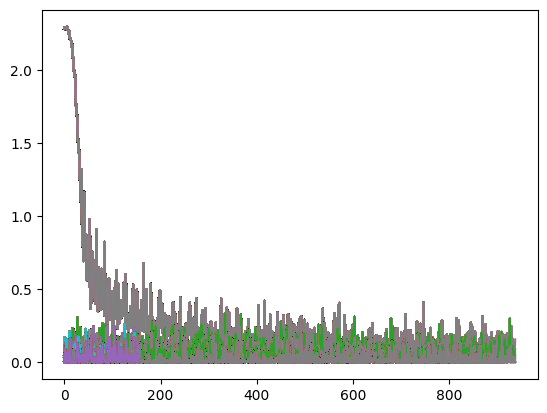

In [9]:
final_acc = final_loop(train_dataloader,test_dataloader,model, criterion, optimizer, num_epochs=10)